# NIRCam CAL 1477
https://www.stsci.edu/jwst/science-execution/program-information?id=1477  
observed the LMC in a few filters F150W, F187N, F277W, F323N  (narrow filters first)
with the FULL detector and also subarrays SUB160, and SUB64P

The purpose of this activity is to verify that the linearity behavior has not changed.  
The goal is to probe the linearity of a large sample of pixels across the detector.  
This set of observations will allow us to  assess how detector linearity varies with flux (electrons/s) and fluence (total electrons).

Obs 1: A FULL  
Obs 2: B FULL  
Obs 3: A SUB160  
Obs 4: B SUB160  
Obs 5: A SUB64P  
Obs 6: B SUB64P  
subarrays only did the 2 wide filters: F150W, F277W

Dithers:
FULL: 2 dithers separated by (24.56", 24.56") LARGE INTRASCA
SUB160: 4 INTRAMODULEBOX
SUB64P: 4 SUBARRAY_DITHER

smaller subarray data has faster sampling (detector readouts)

https://outerspace.stsci.edu/display/JWSTCC/CAL-NRC-005  
via https://outerspace.stsci.edu/pages/viewpage.action?pageId=33424361  

## Download JWST NIRCam images from MAST

#### Select using program ID and specific NIRCam detectors

https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data  
https://github.com/ceers/ceers-nircam/blob/main/ceersdownload.py  

also see:  
https://spacetelescope.github.io/jdat_notebooks/notebooks/NIRSpec_MAST_Query/NIRSpec_MAST_Query.html  
https://mast.stsci.edu/api/        
https://github.com/gbrammer/mastquery/blob/master/mastquery/jwst.py  

In [12]:
import astroquery
from astroquery.mast import Observations

from astropy.table import Table, vstack, unique
from astropy.io import fits

import numpy as np
import os
home = os.path.expanduser("~")
from glob import glob

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  # make colorbar same height as image plot
#from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch, AsinhStretch, SqrtStretch

# Format: larger fonts
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=20)

# Pipeline Stages
1. uncal –> rate
2. rate –> cal
3. cal –> i2d

https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [2]:
import fnmatch

def select_jwst_files(filename_list, program='?????', observation='???', visit='???', group='??', prime_parallel='?', activity='??', 
                      exposure='?????', detector='*', filetype='*', extension='fits'):
    #if type(observation) in (int, float):
    observation = '%03d' % observation
    search_string = 'jw' + program + observation + visit \
        + '_' + group + prime_parallel + activity + '_' + exposure \
        + '_' + detector + '_' + filetype + '.' + extension

    return fnmatch.filter(filename_list, search_string)

In [3]:
def download_jwst_files(proposal_id, download_datatype, output_dir='', observation='???', detector='*'):
    # https://github.com/ceers/ceers-nircam/blob/main/ceersdownload.py 
    obs_table = Observations.query_criteria(obs_collection='JWST', proposal_id=[proposal_id], instrument_name=instrument, 
                                            dataproduct_type='IMAGE')  #filters=file_filters, 
    
    products_list = Observations.get_product_list(obs_table)  # all output products including images, catalogs, etc.
    
    products = Observations.filter_products(products_list, productType=['SCIENCE'], productSubGroupDescription=download_datatype)
    
    files = unique(products, keys='productFilename')
    all_filenames = files['productFilename']
    chosen_files = select_jwst_files(all_filenames, observation=observation, detector=detector)
    
    # Download data
    # https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data
    #manifest = Observations.download_products(chosen_obsIDs, download_dir=DOWNLOAD_DIR)  # , flat=True

    downloaded_files = []
    for filename in chosen_files:
        mast_path  = os.path.join(mast_dir,   filename)
        local_path = os.path.join(images_dir, filename)
        Observations.download_file(mast_path, local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

# Start here

Retrieve data from MAST:

In [4]:
mast_dir = 'mast:jwst/product'

# Define and create directory to save downloads
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)

In [5]:
instrument = 'NIRCAM/IMAGE'
download_datatype = 'UNCAL'  # UNCAL, RATE, CAL, I2D

In [8]:
# Select data
proposal_id = 1477  # Program number
observation = 2  # FULL subarray; Module B
detector = 'nrcblong'  # 'nrcb2'  # *b1

In [9]:
obs_table = Observations.query_criteria(obs_collection='JWST', proposal_id=[proposal_id], instrument_name=instrument, 
                                        dataproduct_type='IMAGE')  #filters=file_filters, 

products_list = Observations.get_product_list(obs_table)  # all output products including images, catalogs, etc.

products = Observations.filter_products(products_list, productType=['SCIENCE'], productSubGroupDescription=download_datatype)

files = unique(products, keys='productFilename')
all_filenames = files['productFilename']
chosen_files = select_jwst_files(all_filenames, observation=observation, detector=detector)

chosen_files

['jw01477002001_02101_00001_nrcblong_uncal.fits',
 'jw01477002001_02101_00002_nrcblong_uncal.fits',
 'jw01477002001_02103_00001_nrcblong_uncal.fits',
 'jw01477002001_02103_00002_nrcblong_uncal.fits']

In [10]:
# 2 dithers (exposures)
# 2 filters: F323N, F277W

In [14]:
filename = chosen_files[2]  # F277W exposure 1
mast_path  = os.path.join(mast_dir, filename)
local_path = os.path.join(images_dir, filename)
Observations.download_file(mast_path, local_path=local_path)

('COMPLETE', None, None)

In [41]:
hdulist = fits.open(local_path)
hdulist[0].header['FILTER']

'F277W'

In [16]:
uncal_data = fits.getdata(local_path)
uncal_data.shape

(1, 150, 2048, 2048)

In [25]:
uncal_data.max()

65161

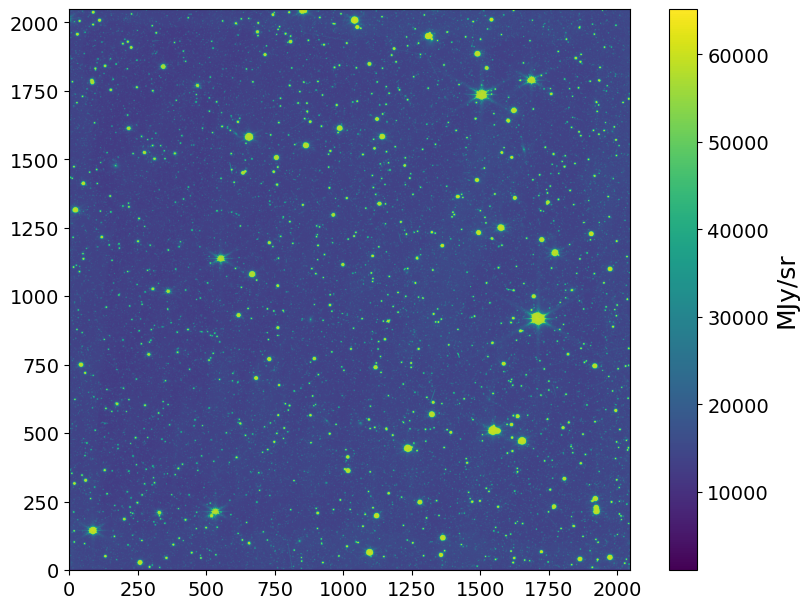

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,8), layout='compressed')
im = plt.imshow(uncal_data[0,-1,:,:], origin='lower')
plt.colorbar(im, ax=ax, label='MJy/sr')

(850.0, 1000.0)

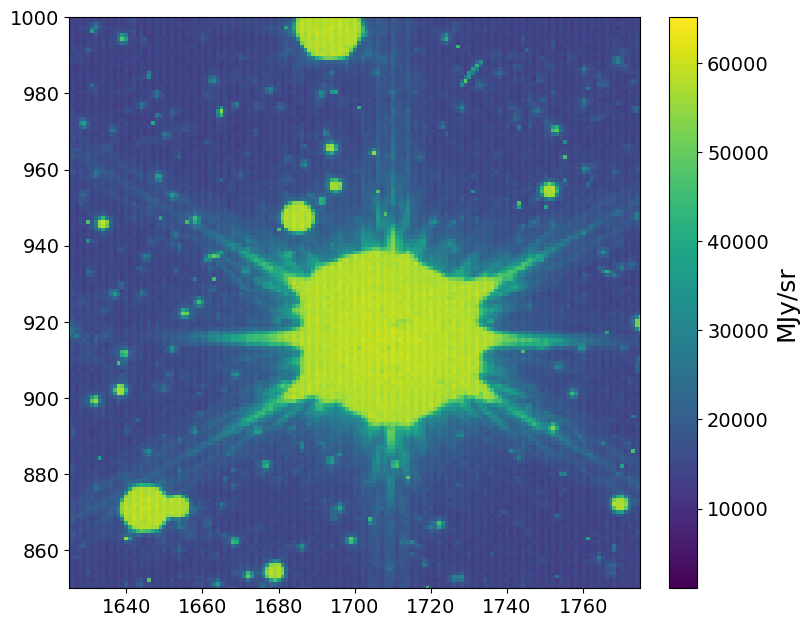

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8,8), layout='compressed')
im = plt.imshow(uncal_data[0,-1,:,:], origin='lower')
plt.colorbar(im, ax=ax, label='MJy/sr')
plt.xlim(1625, 1775)
plt.ylim(850, 1000)

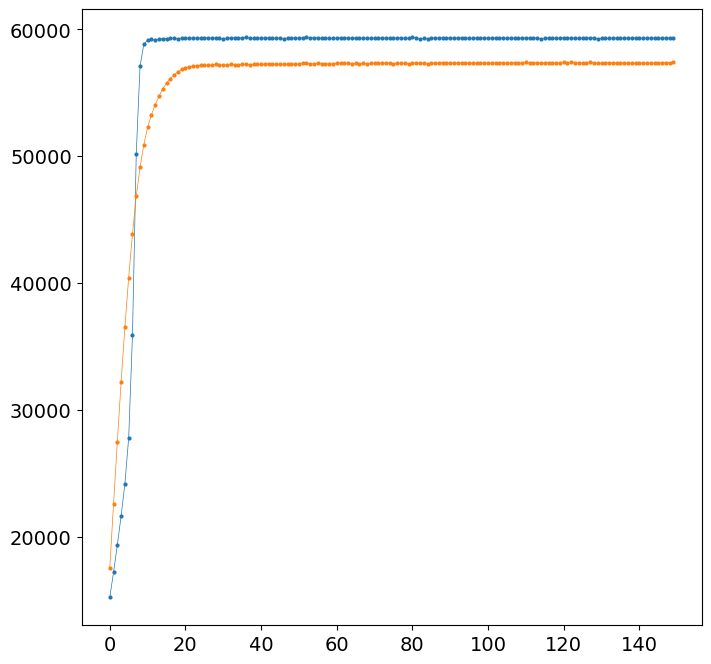

In [33]:
x, y = 1700, 920
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.plot(uncal_data[0,:,y,x], 'o-', ms=2, lw=0.5)
plt.plot(uncal_data[0,:,947,1685], 'o-', ms=2, lw=0.5)
#plt.xlim(0, 500)

# Subarray data

In [34]:
# Select data
proposal_id = 1477  # Program number
observation = 6  # SUB64P; Module B
detector = 'nrcblong'  # 'nrcb2'  # *b1

In [35]:
chosen_files = select_jwst_files(all_filenames, observation=observation, detector=detector)
chosen_files

['jw01477006001_02102_00001_nrcblong_uncal.fits',
 'jw01477006001_02102_00002_nrcblong_uncal.fits',
 'jw01477006001_02102_00003_nrcblong_uncal.fits',
 'jw01477006001_02102_00004_nrcblong_uncal.fits']

In [42]:
filename = chosen_files[0]  # exposure 1
mast_path  = os.path.join(mast_dir, filename)
local_path = os.path.join(images_dir, filename)
Observations.download_file(mast_path, local_path=local_path)

('COMPLETE', None, None)

In [43]:
hdulist = fits.open(local_path)
hdulist[0].header['FILTER']

'F277W'

In [45]:
uncal_data = hdulist['SCI'].data
uncal_data.shape

(1, 5000, 64, 64)

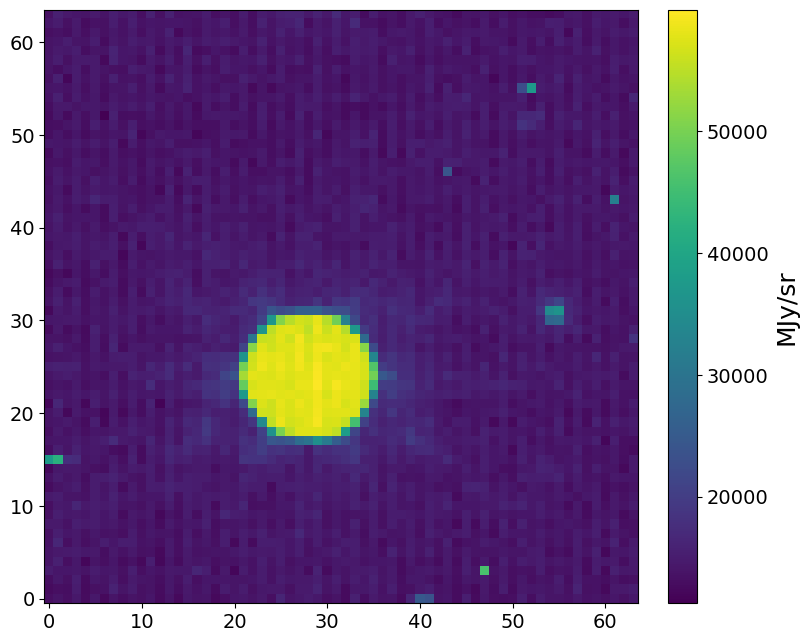

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8,8), layout='compressed')
im = plt.imshow(uncal_data[0,-1,:,:], origin='lower')
plt.colorbar(im, ax=ax, label='MJy/sr')

Text(0, 0.5, 'flux (counts)')

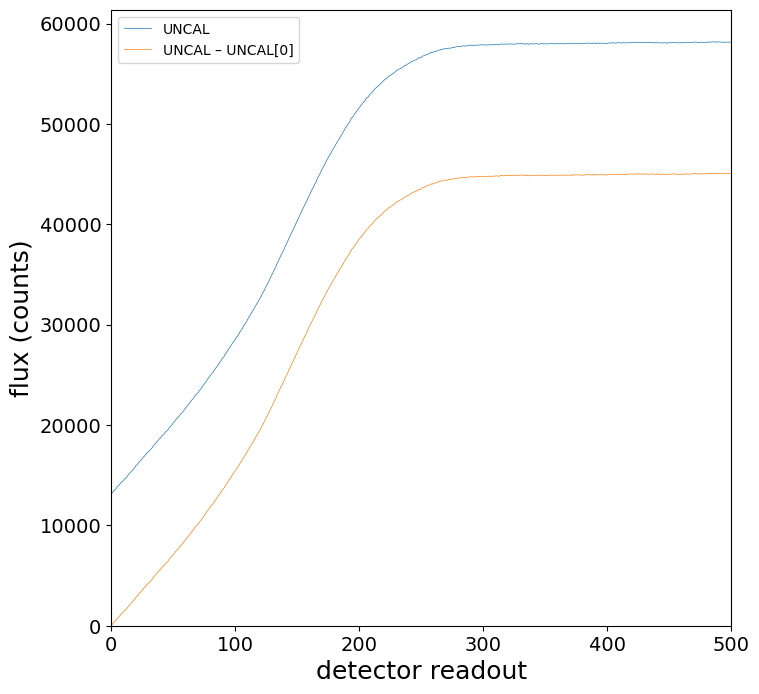

In [67]:
x, y = 27, 23
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.plot(uncal_data[0,:,y,x], lw=0.5, label='UNCAL')
plt.plot(uncal_data[0,:,y,x] - uncal_data[0,0,y,x], lw=0.5, label='UNCAL – UNCAL[0]')
plt.xlim(0, 500)
plt.ylim(0, plt.ylim()[-1])
plt.legend()
plt.xlabel('detector readout')
plt.ylabel('flux (counts)')

(0.0, 50000.0)

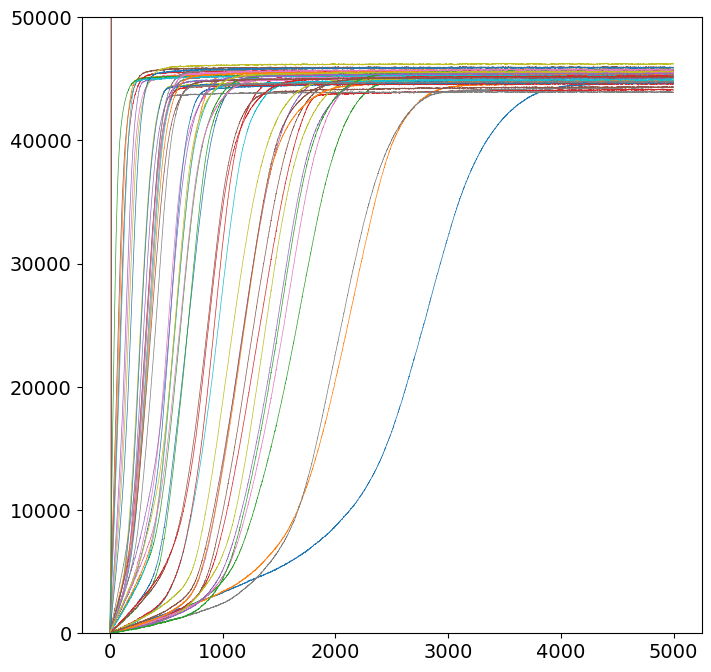

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

for y in np.arange(20, 27):
    for x in np.arange(24, 31):
        plt.plot(uncal_data[0,:,y,x] - uncal_data[0,0,y,x], lw=0.5)

#plt.xlim(0, 500)
plt.ylim(0, 50000)